# Chapter 17: Constrained least squares applications 

## 17.1 Portfolio optimization 

**Compounded portfolio value.** The cummulative value of a portfolio from a return time series vector $r$, starting from $V_1 = \$10000$, is given by the value time series vector $v$, where 

\begin{align}
v_t = V_1 (1+r_1)\cdots(1+r_{t-1}), \quad t=1,\dots,T.
\end{align}

Julia has a built-in function, `cumprod`.

In [1]:
cummulative_value(r; v1=10000) = v1 * cumprod(1 .+ r)

cummulative_value (generic function with 1 method)

In [3]:
# Generate random returns sequence with 10% annualized return, 5% annualized risk 
T = 250;
mu = .10/T; sigma = .05 / sqrt(T);
r = mu .+ sigma*randn(T);
v = cummulative_value(r);

For small per-period returns we have 

\begin{align}
v_t &= V_1 (1+r_1)\cdots(1+r_{t-1})\\
    &\approx  V_1 + V_1(r_1 + \cdots + r_{t-1})\\
    &= V_1 + T \textbf{avg}(r)V_1
\end{align}

so the return $r$ approximates the average per-period increase in portfolio value

In [8]:
# compare compounded value and average return approximation shown above 
using LinearAlgebra
using VMLS
v[T], v[1]*(1+sum(r)), v[1]*(1+T*avg(r))

(11185.88116865124, 11135.751924034965, 11135.751924034965)

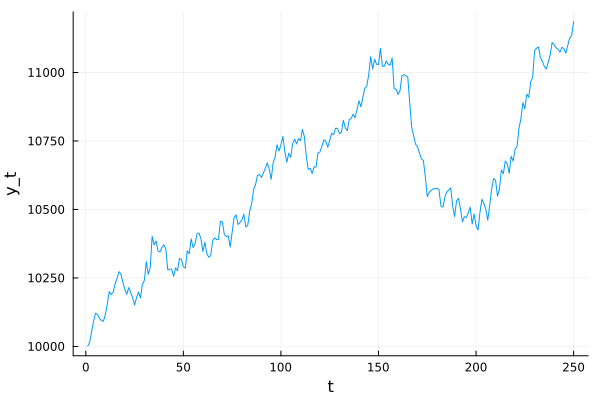

In [10]:
# Plot cummulative value over the year 
using Plots 
plot(1:T, v, legend=false)
plot!(xlabel="t",ylabel="y_t")

**Portfolio optimization.** Define a function `port_opt` to evaluate the solution of the CLS problem in VMLS and apply to the return data .

In [12]:
function port_opt(R,rho)
    T, n = size(R)
    A = R 
    b = rho * ones(T)
    C = [ones(n)';((R'*ones(T))/T)']
    d = [1; rho]
    xhat = cls_solve(A,b,C,d)
    return xhat
end;

In [20]:
R, Rtest = portfolio_data();
T,n = size(R);
P = 250
rho = .10/P; # 10% annual return 
w = port_opt(R,rho);
r = R*w; # portfolio return time series 
pf_return = P*avg(r); pf_risk = sqrt(P)*stdev(r)
pf_return, pf_risk

(0.09999999999999995, 0.08650183086854626)

In [27]:
r20 = R*port_opt(R, .2/P)
r40 = R*port_opt(R, .4/P)
r_uniform = R*(ones(n)/n);

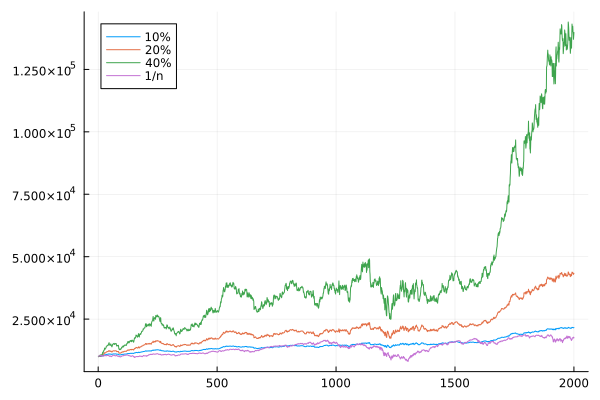

In [26]:
using Plots 
plot(1:T, cummulative_value(r), label="10%")
plot!(1:T, cummulative_value(r20), label="20%")
plot!(1:T, cummulative_value(r40), label="40%")
plot!(1:T, cummulative_value(r_uniform), label="1/n")

## 17.2 Linear quadratic control

We will implement linear quadratic control for a time-invariant system with matrices A, B, and C. 

**Kronecker product.** 

To create the big matrices $\tilde A$ and $\tilde C$ for our CLS problem, we need to define block diagonal matrices with the same matrix repeated along the diagonal. 

One way to do this in Julia is to use the `kron` function for the Kronecker product of 2 matrices. The Kronecker product of a matrix $m \times n$ matrix $G$ and a $p \times q$ matrix $H$ results in the following $mp \times nq$ block matrix:

\begin{align}
\begin{bmatrix}
    G_{11}H & G_{12}H & \dots G_{1n}H \\
    G_{21}H & G_{22}H & \dots G_{2n}H \\
    G_{m1}H & G_{m2}H & \dots G_{mn}H \\
\end{bmatrix}
\end{align}

In [30]:
# example of the Kronecker product and how to utilize for our application of block diagonal matrices
H = randn(2,2)
kron(eye(3),H)

6×6 Matrix{Float64}:
  1.93637   1.28396    0.0       0.0        0.0       0.0
 -1.70969  -0.169099  -0.0      -0.0       -0.0      -0.0
  0.0       0.0        1.93637   1.28396    0.0       0.0
 -0.0      -0.0       -1.70969  -0.169099  -0.0      -0.0
  0.0       0.0        0.0       0.0        1.93637   1.28396
 -0.0      -0.0       -0.0      -0.0       -1.70969  -0.169099

Another way (not using the `kron` function) uses the `cat` function for construction block matrices.

In [36]:
cat([H for k=1:3]..., dims=(1,2))

6×6 Matrix{Float64}:
  1.93637   1.28396    0.0       0.0        0.0       0.0
 -1.70969  -0.169099   0.0       0.0        0.0       0.0
  0.0       0.0        1.93637   1.28396    0.0       0.0
  0.0       0.0       -1.70969  -0.169099   0.0       0.0
  0.0       0.0        0.0       0.0        1.93637   1.28396
  0.0       0.0        0.0       0.0       -1.70969  -0.169099

### Linear quadratic control setup (as CLS problem)

Consider a time-varying **linear dynamical system** with state $n$-vector $x_t$ and input $m$-vector $u_t$, with dynamics equations

\begin{align}
    x_{t+1} = A_t x_t + B_t u_t, \quad t = 1,2,\dots
\end{align}

The system has an output, $p$-vector $y_t$, given by
\begin{align}
    y_{t} = C_t x_t , \quad t = 1,2,\dots
\end{align}

*Note*: Usually, $m \leq n, p \leq n$, i.e. there are fewer inputs and outputs than states.

**Linear quadratic control** refers to the problem of choosing the input and state sequences over a time period $t = 1,\dots,T$ so as to minimize a sum of sequares objective, subject to the dynamics euqations and output equations above, and addition linear equality constraints. Most problems also include an *initial state constraint* ($x_1 = x^{init}$) and a *final state constraint* ($x_T = x^{des}$). 

The objective function has the form $J = J_{output} + \rho J_{input}$, where 

\begin{align}
    J_{output} = ||y_1||^2 + \cdots + ||y_T||^2 = ||C_1 x_1||^2 + \cdots + ||C_T x_T||^2 ,
    J_{input} = ||u_1||^2 + \cdots + ||u_{T-1}||^2. 
\end{align}


The **linear quadratic control problem** (with initial and final state constraints) is to 
\begin{align}
    \text{minimize} \quad & J_{output} + \rho J_{input}\\
    \text{subject to} \quad & x_{t+1} = A_t x_t + B_t u_t, \quad t=1,\dots,T-1,\\
                            & x_1 = x^{init}, \quad x_T = x^{des},\\
\end{align}

where the variables to be chosen are $x_1, \dots, x_T$ and $u_1, \dots, u_{T-1}$


#### Formulation as a CLS problem. 

We define the vector $z$ of all these variables, stacked: 

\begin{align}
z = (x_1, \dots, x_T, u_1, \dots, u_{T-1})
\end{align}

The dimensions of $z$ is $Tn + (T-1)m$.

The control objective can be expressed as $||\tilde A z - \tilde b||^2$, where $\tilde b = 0$ and A is the block matrix 

\begin{align}
    \tilde A = \left[ 
    \begin{array}{c c c c | c c c}
        C_1 & & & & & & \\
        & C_2 & & & & & \\
        & & \ddots & & & & \\
        & & & C_T  & & & \\
        \hline 
        & & & & \sqrt{\rho} I \\
        & & & & & \ddots \\
        & & & & & & \sqrt{\rho} I \\
    \end{array} \right] .
\end{align}

*Note*: In the matrix A, (block) entires not shown are zero, and the identity matrices have dimension $m$. 

The dynamics constraints, and the initial and final state constraints, can be expressed as $\tilde C z = \tilde d$, with 

\begin{align}
    \tilde C = \left[ 
    \begin{array}{c c c c c | c c c c}
        A_1 & -I & & & & B_1 & \\
        & A_2 & -I & & & & B_2\\
        & & \ddots & \ddots & & & & \ddots \\
        & & & A_{T-1} & -I & & & & B_{T-1}\\
        \hline 
        I \\
        & & & &I& \\
    \end{array} \right] , 
    \qquad 

    \tilde d = \left[ 
    \begin{array}{c}
        0 \\
        0 \\
        \vdots \\
        0 \\ 
        \hline 
        x^{init} \\
        x^{des} \\
    \end{array} \right] , 
\end{align}

The solution $\hat z$ of the CLS problem
\begin{align}
    \text{minimize} \quad & ||\tilde A z - \tilde b||^2\\
    \text{subject to} \quad & \tilde C z = \tilde d
\end{align}

gives us the optimal input trajectory and the associated optimal state (and output) trajectory. 

*Note:* The solution $\hat z$ is a linear function of $\tilde b$ and $\tilde d$; since here $\tilde b = 0$, it is a linear function of $x^{init}$ and $x^{des}$

**Linear quadratic control example.** 

We will write a function `lqr` that constructs and solves the CLS problem for linear quadratic control. 

The function returns three arrays: 
```
x = [ x[1], x[2], ..., x[T] ],
u = [ u[1], u[2], ..., u[T-1] ],
y = [ y[1], y[2], ..., y[T] ].
```

The first two contain the optimal solution of the problem. The third array contains $y_t = Cx_t.$

In [226]:
function lqr(A,B,C,xinit,xdes,T,rho)
    n,m = size(B[:,:])
    p,n = size(C)

    # define q to allow xinit and xdes to be matrices 
    q = size(xinit,2)

    # construct A tilde 
    AA = kron(eye(T), C); # left top block matrix is a diagonal block matrix of C 
    #print(size(AA))
    AB = zeros(p*T, (T-1)*m) # right top block matrix is all zeros 
    #print(size(AB))
    AC = zeros((T-1)*m, n*T) # lower left block matrix is all zeros 
    #print(size(AC))
    AD = kron(eye(T-1), sqrt(rho)*eye(m));
    Atilde = [AA AB;
         AC AD];

    # construct b tilde 
    btilde = zeros(size(Atilde,1), q); # zeros with # rows = A's rows 

    #println(size(Atilde))
    #println(length(btilde))

    # construct  C tilde 
    CA = [kron(eye(T-1), A) zeros(n*(T-1), n)] + [zeros(n*(T-1), n) kron(eye(T-1), -eye(n))] 
    CB = kron(eye(T-1), B)
    CC = [eye(n) zeros(n, (T-1)*n);
          zeros(n, (T-1)*n) eye(n)]
    CD = zeros(size(CC, 1), size(CB, 2))
    Ctilde = [CA CB;
              CC CD]

    dtilde = [zeros(size(CA,1), q) ; xinit; xdes]

    zhat = cls_solve(Atilde, btilde, Ctilde, dtilde);
    xs = zhat[1:T*n, :]
    us = zhat[T*n+1:end, :]
    #println(length(xs))
    #println(length(us))

    x = [xs[i*n+1:(i+1)*n,:] for i=0:T-1]
    u = [us[i*m+1:(i+1)*m,:] for i=0:T-2]
    y = [C*xt for xt in x]
    return x,u,y
end;

**Example Details**: We consider the time-invariant linear dynamical system with 

\begin{align}
A = \begin{bmatrix} 
    0.855 & 1.161 & 0.667\\
    0.015 & 1.073 & 0.053\\
    -0.084 & 0.059 & 1.022
    \end{bmatrix}, \qquad
  B = \begin{bmatrix} 
   -0.076\\
     -0.139\\
     0.342
    \end{bmatrix},   \\
    \\
C = \begin{bmatrix} 
    0.218 & -3.597 & -1.683 
    \end{bmatrix},
\end{align}

with iniital condition $x^{init} = (0.496, -0.745, 1.394)$ and desired final state $x^{des} = 0$, and $T = 100.$ 

In this example, both the input $u_t$ and output $y_t$ have dimension one (i.e. are scalar). 

In [334]:
A = [ 0.855 1.161 0.667;
      0.015 1.073 0.053;
      -0.084 0.059 1.022 ];
B = [-0.076;
     -0.139;
     0.342 ];
C = [ 0.218 -3.597 -1.683 ];
n = 3; p = 1; m = 1;
xinit = [0.496; -0.745; 1.394];
xdes = zeros(n,1);

In [335]:
T = 100;
rho = .2; 
x,u,y = lqr(A,B,C,xinit,xdes,T,rho);
Jinput = norm(u)^2; Joutput = norm(y)^2;
Jinput, Joutput

(0.7738942551159613, 3.782998646332541)

Below, we plot the output with respect to time when the input $u_t$ is always zero, so the $B_t u_t$ term disappears, i.e.

\begin{align}
y_t = C A^{t-1} x^{init}, \quad t=1,\dots,T. 
\end{align}

which is called the open-loop output. 

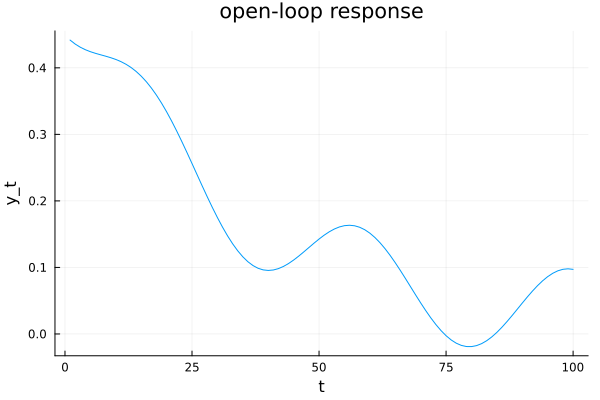

In [308]:
# plot open loop of VMLS figure 
X_ol = [x_init zeros(n, T-1)]
for k=1:T-1
    X_ol[:,k+1] = A*X_ol[:,k];
end;
y_ol = C*X_ol;
plot(1:T, y_ol', legend=false, title="open-loop response",
     xlabel="t", ylabel="y_t")

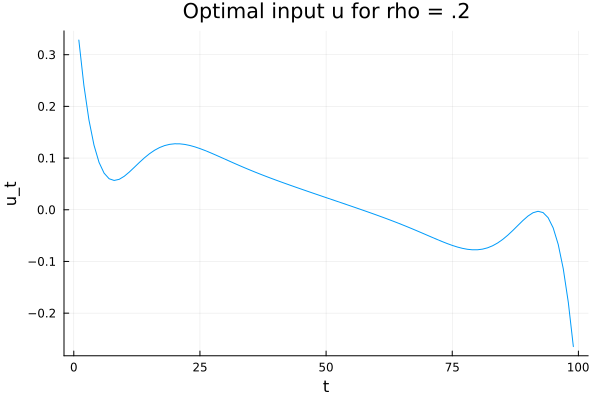

In [231]:
plot(1:T-1, vcat(u...), legend=false, xlabel="t", ylabel="u_t", title="Optimal input u for rho = .2")

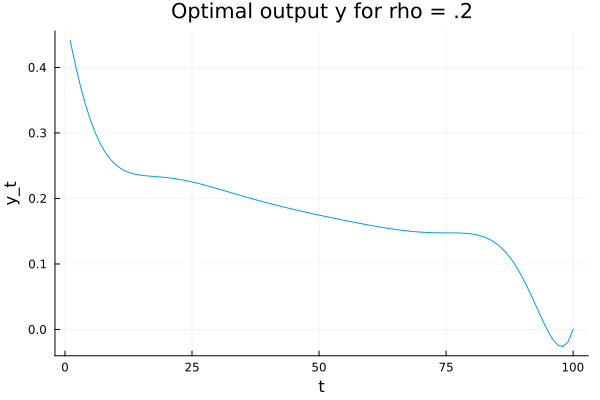

In [232]:
plot(1:T, vcat(y...), legend=false, xlabel="t", ylabel="y_t", title="Optimal output y for rho = .2")

now we'll compare the inputs and outputs for different rhos: 

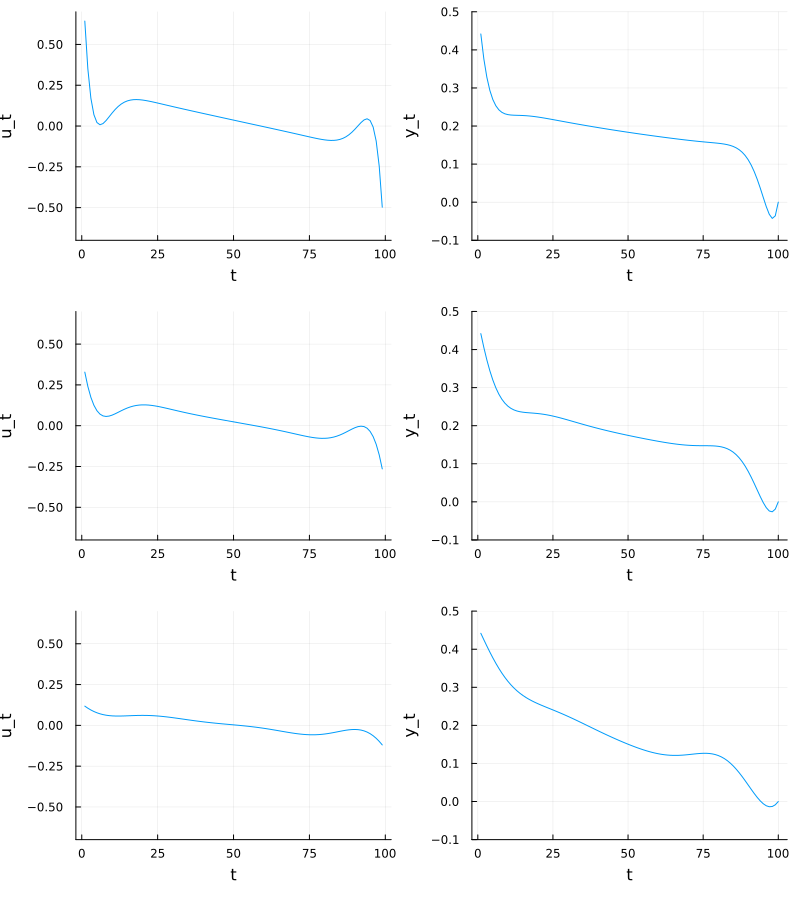

In [333]:
T = 100;
rhos = [.05, .2, 1]; 

using Plots 
p = plot(layout=(3,2), legend=false, size=(800,900))
for k=1:length(rhos)
    x,u,y = lqr(A,B,C,xinit,xdes,T,rhos[k]);
    plot!(1:T-1, vcat(u...), legend=false, xlabel="t", ylabel="u_t", subplot=(2*k-1), ylim=(-.7,.7))
    plot!(1:T, vcat(y...), legend=false, xlabel="t", ylabel="y_t", subplot=(2*k), ylim=(-.1,.5))
end

scatter!(title="")
# Jinput = norm(u)^2; Joutput = norm(y)^2;

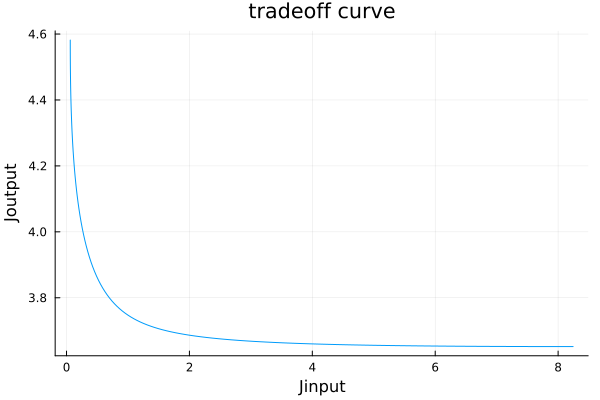

In [339]:
N = 200
rhos = 10 .^ linspace(-4,4,N);

Joutputs = zeros(N)
Jinputs = zeros(N)

for k=1:N
    x,u,y = lqr(A,B,C,xinit,xdes,T,rhos[k]);
    Joutputs[k] = norm(y)^2
    Jinputs[k] = norm(u)^2
end;

# plot tradeoff curve 
plot(Jinputs, Joutputs, legend=false, xlabel="Jinput", ylabel="Joutput", title="tradeoff curve")

**Linear state feedback control.** We measure the state in each period and use the input 

\begin{align}
u_t = K x_t 
\end{align}

The matrix $K$ is called the *state feedback gain matrix.* 

**Example**. 

In [269]:
rho = 1.0; # simulate with rho = 1

# solve LQ problem with xinit = I, xdes = 0 to get K matrix 
xsf, usf, ysf = lqr(A,B,C, eye(n), zeros(n,n), T, rho);
K = usf[1]

1×3 Matrix{Float64}:
 0.308329  -2.65865  -1.44602

In [270]:
# simulate state, input, and output using the state feedback gain matrix
TT = 150;
Xsf = [xinit zeros(n, TT-1)];
Usf = zeros(TT-1,m);
for t=1:TT-1
    Usf[t, :] = K*Xsf[:,t]
    Xsf[:, t+1] = A*Xsf[:, t] + B * (Usf[t,:]')
end;
Ysf = C*Xsf;
Jinputsf = norm(Usf)^2; Joutputsf = norm(Ysf)^2;
Jinputsf, Joutputsf

(0.23856526056023303, 3.631288895297139)

In [274]:
# now solve using our linear quadratic control CLS problem for new rho
x1,u1,y1 = lqr(A,B,C,xinit,xdes,TT,rho);
Jinput = norm(u1)^2; Joutput = norm(y1)^2;
Jinput, Joutput

(0.2906381041059095, 3.622433963534506)

In [293]:
# now solve using our linear quadratic control CLS problem for new rho
# this time just for original T = 100 
x2,u2,y2 = lqr(A,B,C,xinit,xdes,T,rho);
Jinput = norm(u2)^2; Joutput = norm(y2)^2;
Jinput, Joutput

(0.24567823834811617, 4.020937585096671)

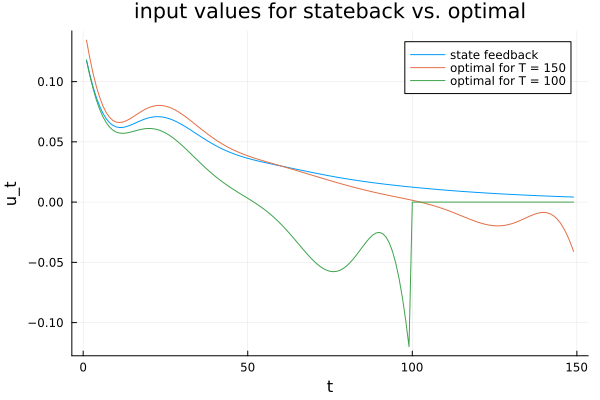

In [305]:
# plot the inputs for optimal vs. state feedback 
plot(1:TT-1, Usf, label="state feedback")
plot!(1:TT-1, vcat(u1...), label="optimal for T = 150")
plot!(1:TT-1, [vcat(u2...); zeros(TT-T, 1)], label="optimal for T = 100")
plot!(xlabel="t", ylabel="u_t", title="input values for stateback vs. optimal")

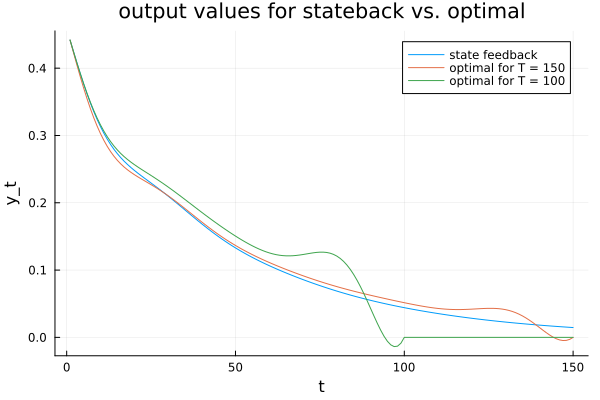

In [306]:
# plot the OUTPUTS for optimal vs. state feedback 
plot(1:TT, Ysf', label="state feedback")
plot!(1:TT, vcat(y1...), label="optimal for T = 150")
plot!(1:TT, [vcat(y2...); zeros(TT-T, 1)], label="optimal for T = 100")
plot!(xlabel="t", ylabel="y_t", title="output values for stateback vs. optimal")

## 17.3 Linear quadratic state estimation 

*The code and problem setup is very similar to linear quadratic control:*

A linear dynamical system of the form 
\begin{align}
x_{t+1} = A_t x_t + B_t w_t, \qquad y_t = C_t + v_t, \quad t=1,2,\dots
\end{align}

$x_t$ - state 
$y_t$ - measurement 
$w_t$ - input or process noise 
$v_t$ - measurement noise or residual 

In *state estimation*, $A_t, B_t, C_t, y_1, \dots, y_T$ are known but process / measurement noises are unknown. 

Goal: guess / est. the state sequence $x_1, \dots, x_T$ 

Because we don't know the process or measurement noises, we guess the state sequence and process noise sequence $w_1, \dots, w_{T-1}$ subject to the requirement that they satisfy the dynamic system model. 

When we guess the state sequence, we implicitly guess that the measurement noise is $v_t = y_t - C_t x_t$. We **assume** that the process and measurement noises are both small. 

1) Our primary objective is the sum of norms squared of the measurement noise/residuals, 

\begin{align}
J_{meas} &= ||v_1||^2 + \dots + ||v_T||^2\\
         &= ||C_1 x_1 - y_1||^2 + \dots + ||C_T x_T - y_T||^2 .
\end{align}

- Meaning: if this is small, the proposed state sequence guess is consistent with our measurements. 

2) The secondary objective is the sum of norms squared of the process noise, 

\begin{align}
J_{proc} &= ||w_1||^2 + \dots + ||w_{T-1}||^2.
\end{align}

- Meaning: Our assumption that the process noise is small corresponds to this objective being small. 

**least squares state estimation** This is a CLS problem to guess $x_1,\dots,x_T,w_1,\dots,w_{T-1}$ so as to minimize our objectives, subject to the dynamics constraints: 

\begin{align}
    &\text{minimize} \quad J_{meas} + \lambda J_{proc}\\
    &\text{subject to} \quad x_t = A_t x_t + B_t w_t, \quad t = 1, \dots, T-1
\end{align}

where $\lambda$ means the weight/trust we put into the measurements. $\lambda$ can be chosen using validation. 

**Estimation versus control.** Though the problem setup is very similar (sometimes called *control/estimation duality*), the interpretation is quite different. In the control problem, we choose the inputs and then we know the state sequence from them. In the estimation problem, the inputs (aka process noise) are unknown and the problem is to guess them. Our job is to guess the state sequence which is unknown. We are not choosing inputs but rather observing hte outputs and deducing the state sequence. 

#### Formulation as a CLS problem. 

We define the vector $z$ of all these variables, stacked: 

\begin{align}
z = (x_1, \dots, x_T, w_1, \dots, w_{T-1})
\end{align}

The control objective can be expressed as $||\tilde A z - \tilde b||^2$, where

\begin{align}
    \tilde A = \left[ 
    \begin{array}{c c c c | c c c}
        C_1 & & & & & & \\
        & C_2 & & & & & \\
        & & \ddots & & & & \\
        & & & C_T  & & & \\
        \hline 
        & & & & \sqrt{\lambda} I \\
        & & & & & \ddots \\
        & & & & & & \sqrt{\lambda} I \\
    \end{array} \right] ,
    \qquad

    \tilde b = \left[ 
    \begin{array}{c}
        y_1 \\
        y_2 \\
        \vdots \\
        y_T \\ 
        \hline 
        0 \\
        \vdots \\
        0 \\
    \end{array} \right] , 
\end{align}

The dynamics constraints, and the initial and final state constraints, can be expressed as $\tilde C z = \tilde d$, with 

\begin{align}
    \tilde C = \left[ 
    \begin{array}{c c c c c | c c c c}
        A_1 & -I & & & & B_1 & \\
        & A_2 & -I & & & & B_2\\
        & & \ddots & \ddots & & & & \ddots \\
        & & & A_{T-1} & -I & & & & B_{T-1}\\
    \end{array} \right] , 
    \qquad 

    \tilde d = \left[ 
    \begin{array}{c}
        0 \\
        0 \\
        \vdots \\
        0 
    \end{array} \right] , 
\end{align}

The solution $\hat z$ of the CLS problem
\begin{align}
    \text{minimize} \quad & ||\tilde A z - \tilde b||^2\\
    \text{subject to} \quad & \tilde C z = \tilde d
\end{align}

The least squares state estimation problem was formulated by Rudolf Kalman and others. He and others developed a particular recursive algorithm for solving the problem, and the whole method has come to be known as *Kalman filtering*. 

In [383]:
function lqe(A,B,C,y,T,lambda)
    n,m = size(B[:,:])
    p,n = size(C)

    # construct A tilde 
    AA = kron(eye(T), C); # left top block matrix is a diagonal block matrix of C 
    #print(size(AA))
    AB = zeros(p*T, (T-1)*m) # right top block matrix is all zeros 
    #print(size(AB))
    AC = zeros((T-1)*m, n*T) # lower left block matrix is all zeros 
    #print(size(AC))
    AD = kron(eye(T-1), sqrt(lambda)*eye(m));
    Atilde = [AA AB;
         AC AD];

    # construct b tilde 
    btilde = [vcat(y...) ; zeros(m*(T-1))]; 

    # construct  C tilde 
    CA = [kron(eye(T-1), A) zeros(n*(T-1), n)] + [zeros(n*(T-1), n) kron(eye(T-1), -eye(n))] 
    CB = kron(eye(T-1), B)
    Ctilde = [CA CB]

    dtilde = zeros(n*(T-1))

    zhat = cls_solve(Atilde, btilde, Ctilde, dtilde);
    xs = zhat[1:T*n]
    ws = zhat[T*n+1:end]

    x = [xs[i*n+1:(i+1)*n] for i=0:T-1]
    w = [ws[i*m+1:(i+1)*m] for i=0:T-2]
    y = [C*xt for xt in x]
    return x,w,y
end;

### 17.3.1 Example 

Consider a system with $n = 4, p = 2, m = 2$ and time-invariant matrices 

\begin{align}
A = \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
\end{bmatrix},
\quad 
B = \begin{bmatrix}
    0 & 0 \\
    0 & 0 \\
    1 & 0 \\
    0 & 1 
\end{bmatrix},
\quad
C = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 
\end{bmatrix}.
\end{align}

This is a simple model of a motion of mass moving in 2D. The first 2 components of $x_t$ represent the position coordinates, the last 2 components represent the velocity coordinates. 

The input $w_t$ acts like a force. 

$y_t = Cx_t + v_t$ is a nosiy measurement of the mass position where $Cx_t$ is the exact or true position. 

We will estimate the state trajectory over $t = 1,\dots,T$ 

In [384]:
A = [1 0 1 0;
     0 1 0 1;
     0 0 1 0;
     0 0 0 1];

B = [0 0;
     0 0 
     1 0
     0 1];

C = [1 0 0 0;
     0 1 0 0];

T = 100; 

using VMLS
ymeas = lq_estimation_data()

2×100 Matrix{Float64}:
 17.0778  -18.3924    6.10394  -7.97507  …    295.403    260.828    224.987
 16.3812   -1.02102  -2.62173  17.0421      -1631.71   -1655.47   -1643.58

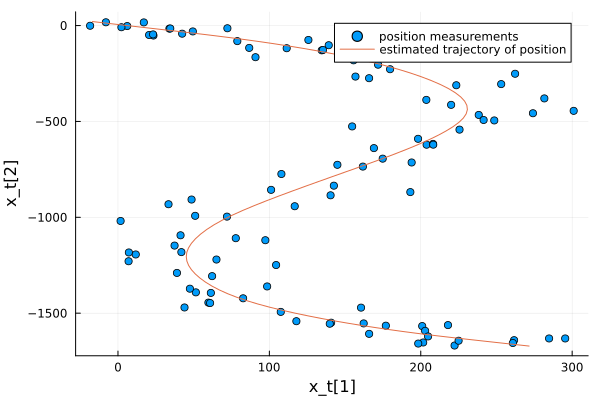

In [444]:
lambda = 1e3; 
xest, west, yest = lqe(A,B,C,ymeas,T,lambda)
scatter(ymeas[1,:], ymeas[2,:], label="position measurements")
plot!([yt[1] for yt in yest], [yt[2] for yt in yest], label="estimated trajectory of position", xlabel="x_t[1]", ylabel="x_t[2]")

### 17.3.3 Validation 

We can use validation to choose $\lambda$. To do this, we can remove some of the measurements and carry out LQE pretending those measurements are missing. We choose a value of $\lambda$ which approximately minimizes this (test) prediction error. 

**Variation: Missing measurements.**  

In [404]:
function lqe_mm(A,B,C,y,idxs,T,lambda)
    n,m = size(B[:,:])
    p,n = size(C)

    Tmeas = length(idxs)

    # construct A tilde 
    AA = kron(eye(T)[idxs, :], C); # left top block matrix is a diagonal block matrix of C 
    #print(size(AA))
    AB = zeros(p*Tmeas, (T-1)*m) # right top block matrix is all zeros 
    #print(size(AB))
    AC = zeros((T-1)*m, n*T) # lower left block matrix is all zeros 
    #print(size(AC))
    AD = kron(eye(T-1), sqrt(lambda)*eye(m));
    Atilde = [AA AB;
         AC AD];


    # construct b tilde 
    btilde = [vcat(y...) ; zeros(m*(T-1))]; 

    # construct  C tilde 
    CA = [kron(eye(T-1), A) zeros(n*(T-1), n)] + [zeros(n*(T-1), n) kron(eye(T-1), -eye(n))] 
    CB = kron(eye(T-1), B)
    Ctilde = [CA CB]

    dtilde = zeros(n*(T-1))

    zhat = cls_solve(Atilde, btilde, Ctilde, dtilde);
    xs = zhat[1:T*n]
    ws = zhat[T*n+1:end]

    x = [xs[i*n+1:(i+1)*n] for i=0:T-1]
    w = [ws[i*m+1:(i+1)*m] for i=0:T-2]
    y = [C*xt for xt in x]
    return x,w,y
end;

In [440]:
ntrain = 80;

import Random
I = Random.randperm(T)
Itrain = I[1:ntrain]
ytrain = ymeas[:, Itrain]
Itest = I[ntrain+1:end]
ytest = ymeas[:, Itest];

In [441]:
lambda = 1e3; 
xest, west, yest = lqe_mm(A,B,C,ytrain,Itrain,T,lambda)
Jmeas(y, yest, C, idxs) = norm(hcat(yest...)[:, idxs] - y)^2
Jmeas(ytrain, yest, C, Itrain)
Jmeas(ytest, yest, C, Itest)

50140.16966359476

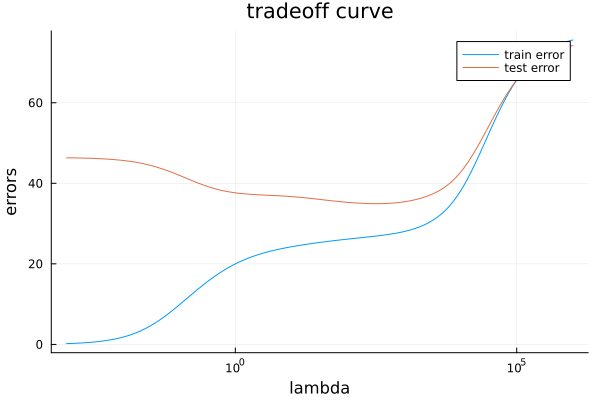

In [442]:
N = 200
lambdas = 10 .^ linspace(-3,6,N);

p = size(C, 1)
Jmeass = zeros(N, 2)

for k=1:N
    xest, west, yest = lqe_mm(A,B,C,ytrain,Itrain,T,lambdas[k])
    Jmeass[k, 1] = (Jmeas(ytrain, yest, C, Itrain) / (length(Itrain)*p))^.5
    Jmeass[k, 2] = (Jmeas(ytest, yest, C, Itest) / (length(Itest)*p))^.5
end;

# plot tradeoff curve 
plot(lambdas, Jmeass[:, 1], xscale=:log10, xlabel="lambda", ylabel="errors", title="tradeoff curve", label="train error")
plot!(lambdas, Jmeass[:, 2], xscale=:log10, label="test error")

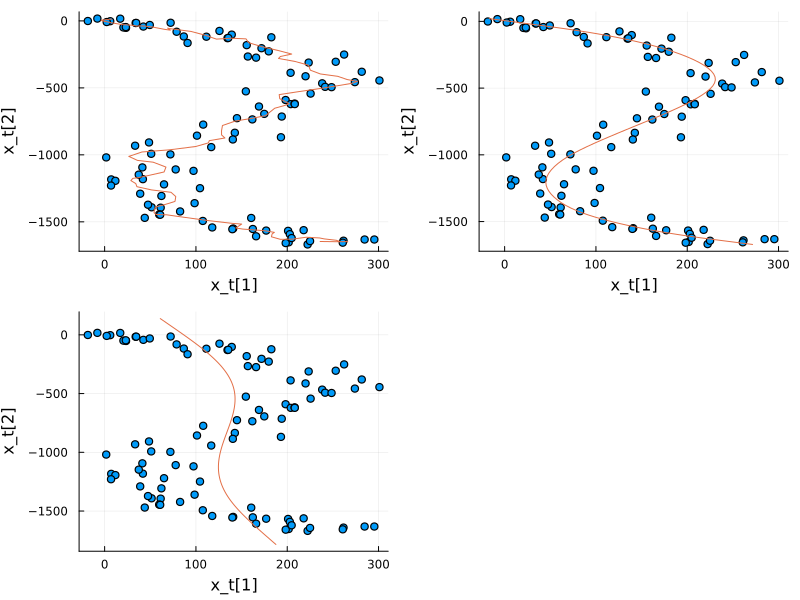

In [451]:
plot_lambdas = [1, 1e3, 1e5]

p = plot(layout=3, legend=false, size=(800,600))
for k=1:length(plot_lambdas)
    xest, west, yest = lqe(A,B,C,ymeas,T,plot_lambdas[k])
    scatter!(ymeas[1,:], ymeas[2,:], label="position measurements", subplot=k)
    plot!([yt[1] for yt in yest], [yt[2] for yt in yest], subplot=k, xlabel="x_t[1]", ylabel="x_t[2]")
end

scatter!(title="")